# Restricted Boltzmann Machines - RBMs



As RBMs podem ser consideradas uma junção entre os campos de deep learning e física, e pode ser muito útil para redução de dimensionalidade, classificação, regressão, filtragem colaborative, etc. 

## Trabalhando com Máquinas de Boltzmann

As máquinas de Boltzmann são inspiradas na distribuição de Boltzmann, a qual diz que o estado do sistema depende de sua energia e da temperatura em que está operando, por isso, dizemos que o modelo é baseado em energia. 

O termo energia aqui é utilizado para comparar a amostragem da rede com os dados originais. Quanto maior a energia, maior é a diferença dos dados. Sendo assim, o modelo é treinado com o objetivo de minimizar essa energia. 

<img src='assets/bm.png' width=800px>

## A intuição por trás das máquinas de Boltzmann...

As máquinas de Boltzmann têm uma arquitetura diferente das demais redes neurais. Não existe uma demarcação clara entre camada de entrada e de saída. Na verdade, não possuem camada de saída. 

Os nós em uma máquina de Boltzmann são categorizados apenas como visíveis ou escondidos. Os nós visíveis recebem os dados de entrada, e são reconstruídos como nos nós de saída. 

Na versão original da máquina de Boltzmann, todos os nós sao conectados, sejam eles das camadas visível ou invisivel, e todas as conexões so bi-direcionais.

<img src='assets/bmGraph.png' width=600px>

Alem disso, cada nó pode assumir apenas dois estados possíveis, ligado (1) ou desligado (0). O estado de um nó é determinado pelos pesos e viéses (bias) associados a ele. 

## Tipos de máquinas de Boltzmann

Existem diversas variações de máquinas de Boltzmann que evoluíram com o tempo para resolver diversos tipos de problemas. Entre as mais conhecidas podemos citar a máquina de Boltzmann Restrita (_Restricted Boltzmann Machine_ - RBM), Redes de Crença Profunda (_Deep Belief Network_ - DBN) e a Máquina de Boltzmann Profunda (_Deep Boltzmann Machine_ - DBM). 

Claro que temos, dentro delas, diferentes versões, como as RBMs Gaussianas, Discriminativas, Híbridas, Convolucionais, etc.

### Restricted Boltzmann Machines

O maior problema da máquina de Boltzmann convencional é a enorme quantidade de cálculos a serem executados mesmo para uma pequena quantidade de dados. Nesses casos, atualizar os pesos da rede se torna uma tarefa muito demorada devido as dependências entre os nós. Para reduzir essa dependência, uma restrição foi imposta ao modelo para remover as conexões intra-camadas.

<img src='assets/bm_rbm.png' width=600px>

Essa restrição imposta às conexoes tornam as unidades de entrada e os nós esondidos independentes dentro de suas camadas. Sendo assim, os pesos podem ser atualizados em paralelo.

<img src='assets/rbmCon.png' width=600px>

### Deep Belief Network e Deep Boltzmann Machines

Deep Belief Network e Deep Boltzmann Machines são versões empilhadas da RBM, criando modelos em profundidade. DBNs são inicializadas aleatoriamente e utilizam cadeias de Markov para definir a ocorrência de possiveis eventos, que sao ajustados durante o processo de treinamento. As DBMs, em contrapartida, tentam oferecer uma solução diferente com um treinamento mais refinado.

<img src='assets/dbn_dbm.png' width=600px>

Apesar das duas arquiteturas serem confundidas frequentemente, a diferença pode ser notada nas conexões. As conexões da DBN nas camadas superiores têm uma única direção, enquanto nas DBMs sao bi-direcionais.

## Implementando RBMs com PyTorch


Vamos implementar a RBM em PyTorch para reconstrução de dígitos usando o dataset MNIST.

### Passo 1: Importando os pacotes necessários

Nesse passo, importamos todos os pacotes. Note que usaremos `torchvision.utils` para visualização dos resultados.

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

### Passo 2: Carregando o dataset MNIST

Esse passo carrega o conjunto de treinamento e teste do dataset MNIST usando a classe Dataloader do pacote `torch.utils.data`. Vamos utilizar um batch de tamanho 64 e aplicar as transformações necessárias.


In [2]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()]) # -> divide por 255 as imagens
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

### Passo 3: Definindo o modelo

Nesse passo, começaremos a construir nosso modelo. Vamos definir as transformações associadas com os neurônios visíveis e escondidos. Além disso, pela RBM ser um modelo baseado em energia, vamos também definir uma função para computar a diferença de energia (neste caso, podemos usar a _Free Energy_. Na inicialização da função, também inicializaremos os pesos e os bias para os neurônios visíveis e escondidos.

In [3]:
class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hid=512, k=1, lr=0.1, momentum=0, decay=0):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_vis, n_hid)*1e-2) # dim = (m, n)
        self.v_bias = nn.Parameter(torch.zeros(n_vis)) 
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.k = k
        self.lr = lr
        self.optimizer = optim.SGD(
            self.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    
    def sample_from_p(self, p):
        return F.relu(torch.sign(p - torch.rand(p.size()))) # para não fazermos if
    
    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W.t(), self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W, self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
    
    def gibbs(self, v):
        pre_h1, h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
            
        return v, v_, pre_h_, h_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v ,self.W.t(), self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        
        return (-hidden_term - vbias_term).mean()
    
    def fit(self, train_loader, epochs):
        
        loss_ = []

        for epoch in range(epochs):
            loss_2 = 0
            for _, (data,target) in enumerate(train_loader):
                data = data.view(-1, self.n_vis) #-> batch x n_vis -> [0, 1]
                #sample_data = data.bernoulli() # -> cada pixel é uma proba de Bernoulli -> binário
                # ou 
                sample_data = data # usamos as probabilidades como entrada, sem amostrar/binarizar

                v, v1, pre_h_, h_ = self.gibbs(sample_data)
                loss = self.free_energy(v) - self.free_energy(v1)
                loss_2 += loss.data        
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            loss_.append(loss_2/len(train_loader))

            print("Training loss for {} epoch: {}".format(epoch+1, loss_[epoch]))
            
        return loss_

    def forward(self, v):
        
        v, v_, pre_h_, h_ = self.gibbs(v)
        
        return h_    

Sempre precisamos definir o método _forward_ (herdado de _nn.Module_), o qual é usado pela rede para propagar os pesos e os bias pela rede e computar todos os valores. 

O processo é repetido por $k$ vezes, o que define o número de vezes em que computamos a divergência constrastiva.
Uma vez que as RBMs são modelos baseados em energia, no fim definimos uma função que calcula a energia livre do modelo.

### Passo 4: Inicializando e treinando o modelo

A classe da RBM que criamos é inicializada com $k=1$. Vamos usar o otimizador SGD no exemplo. No fim do processo, todas os custos são acumulados em um vetor 1D. 

Extrairemos a distribuição de Bernoulli usando o método `data.bernoulli()`. Esse é o padrao de entrada com o qual começaremos.

Uma amostra de entrada é usada para alimentar a RBM, a qual retorna o padrão reconstruído como saída. O erro é calculado como a diferença entre as energias desses dois padrões e adicionada em uma lista. 

O erro é propagado usando o método `backward()`. Já o método `optimizer.step()` executa a atualização dos parâmetros baseando-se no gradiente acumulado, armazenado no atributo `.grad`, executando a atualização de todos os parâmetros.

In [4]:
rbm = RBM(n_vis=784, n_hid=256, k=1, lr=0.1,momentum=0, decay=0)

loss = rbm.fit(train_loader, epochs=20)

Training loss for 1 epoch: -11.939105033874512
Training loss for 2 epoch: -7.931293487548828
Training loss for 3 epoch: -5.947612762451172
Training loss for 4 epoch: -4.485100269317627
Training loss for 5 epoch: -3.3014020919799805
Training loss for 6 epoch: -2.4290647506713867
Training loss for 7 epoch: -1.8373088836669922
Training loss for 8 epoch: -1.3854637145996094
Training loss for 9 epoch: -1.1339839696884155
Training loss for 10 epoch: -0.9099858999252319
Training loss for 11 epoch: -0.6756551861763
Training loss for 12 epoch: -0.5828852653503418
Training loss for 13 epoch: -0.46765193343162537
Training loss for 14 epoch: -0.3437797725200653
Training loss for 15 epoch: -0.21509039402008057
Training loss for 16 epoch: -0.17274419963359833
Training loss for 17 epoch: -0.10215248167514801
Training loss for 18 epoch: -0.08362551778554916
Training loss for 19 epoch: -0.011708144098520279
Training loss for 20 epoch: 0.05840683728456497


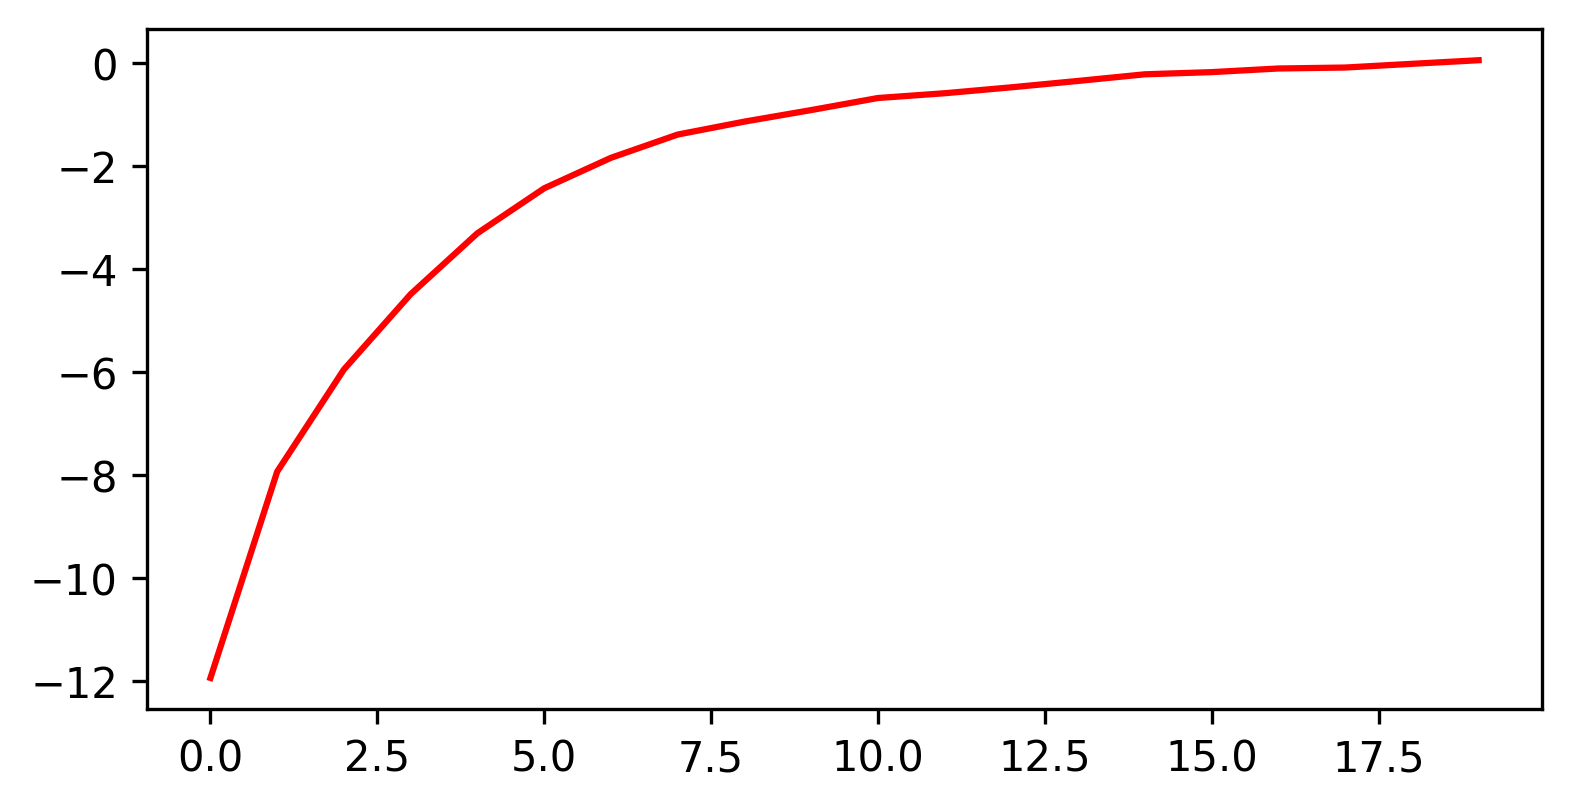

In [5]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(loss, color='red')
plt.show()

Na sequência, definimos uma função auxiliar para transpor a imagem para uma dimensão apropriada e armazená-la.

In [6]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    #plt.imshow(npimg)
    plt.imsave(f,npimg)
    return npimg

### Passo 5: visualizando as saídas

Nesse passo, vamos visualizar as saídas

In [7]:
#test_loader.dataset.

In [8]:
qtd = 32

v, v_, _, _ = rbm.gibbs((test_loader.dataset.data[:qtd]/255.).reshape((qtd,rbm.n_vis)))

real = show_and_save("real", make_grid(v.view(qtd,1,28,28).data))
gen = show_and_save("geradas",make_grid(v_.view(qtd,1,28,28).data))

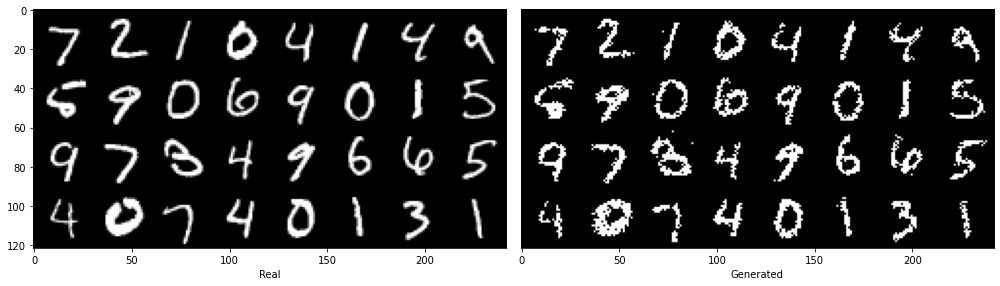

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].imshow(real)
ax[1].imshow(gen)
ax[0].set_xlabel('Real')
ax[1].set_xlabel('Generated')
#ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
#ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

### Passo 6: visualizando os pesos


In [10]:
#import learnergy.visual.image as im
from learnergy.visual.image import _rasterize
from PIL import Image

In [11]:
def create_mosaic(tensor):
    """Creates a mosaic from a tensor using Pillow.
    Args:
        tensor: An input tensor to have its mosaic created.
    """

    # Gets the numpy array from the tensor
    array = tensor.detach().numpy()

    # Calculate their maximum possible squared dimension
    d = int(np.sqrt(array.shape[0]))
    s = int(np.sqrt(array.shape[1]))

    # Creates a Pillow image from the array's rasterized version
    img = Image.fromarray(
        _rasterize(array.T, img_shape=(d, d), tile_shape=(s, s), tile_spacing=(1, 1))
    )

    
    return img

In [12]:
image = create_mosaic(rbm.W)

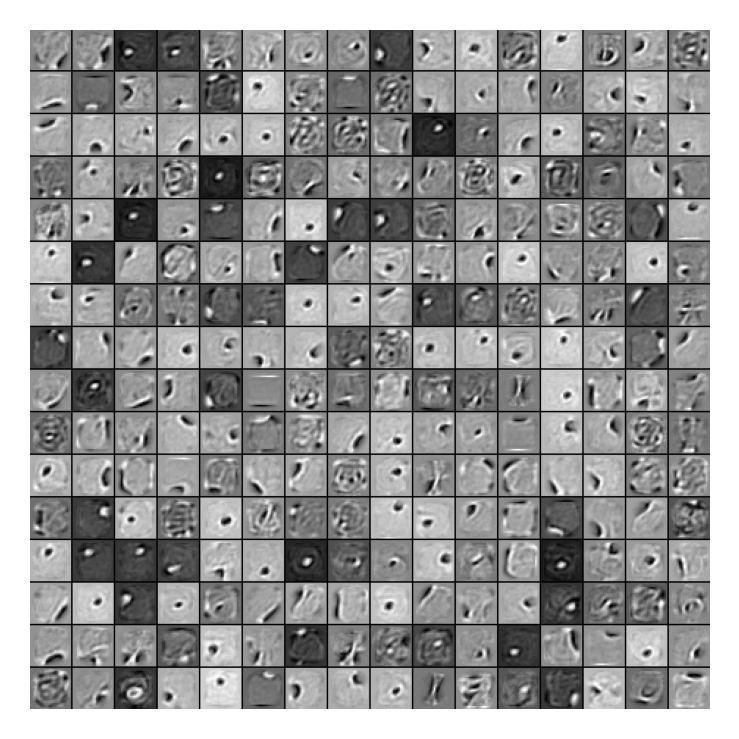

In [13]:
plt.figure(figsize=(6, 3), dpi=300)
plt.imshow(image, 'gray')
plt.axis('off')
#plt.xticks([], [])
#plt.yticks([], [])
plt.show()

### Iremos classificar as imagens utilizando uma simples camada softmax

In [14]:
from torch import nn, optim
import torch.nn.functional as F

class classificador(nn.Module):
    def __init__(self, n_hid=100, n_class=10):
        super().__init__()
        self.fc1 = nn.Linear(n_hid, n_class)
        
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

In [15]:
model = classificador(n_hid=rbm.W.shape[1], n_class=10)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
steps = 0

train_losses, test_losses = [], []

In [16]:
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        images = images.squeeze().view(-1,rbm.n_vis)
        
        features = rbm(images)        
        #_, features = rbm.v_to_h(images)
        
        log_ps = model(features)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:        
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # passo de validação
            for images, labels in test_loader:
                
                images = images.squeeze().view(-1,rbm.n_vis)
                
                features = rbm(images)
                #_, features = rbm.v_to_h(images)
        
                log_ps = model(features)
                ps = torch.exp(log_ps)
                
                test_loss += criterion(log_ps, labels)  
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/15..  Training Loss: 0.610..  Test Loss: 0.355..  Test Accuracy: 0.901
Epoch: 2/15..  Training Loss: 0.341..  Test Loss: 0.308..  Test Accuracy: 0.908
Epoch: 3/15..  Training Loss: 0.308..  Test Loss: 0.280..  Test Accuracy: 0.917
Epoch: 4/15..  Training Loss: 0.297..  Test Loss: 0.283..  Test Accuracy: 0.914
Epoch: 5/15..  Training Loss: 0.284..  Test Loss: 0.269..  Test Accuracy: 0.921
Epoch: 6/15..  Training Loss: 0.282..  Test Loss: 0.270..  Test Accuracy: 0.918
Epoch: 7/15..  Training Loss: 0.277..  Test Loss: 0.264..  Test Accuracy: 0.921
Epoch: 8/15..  Training Loss: 0.275..  Test Loss: 0.262..  Test Accuracy: 0.922
Epoch: 9/15..  Training Loss: 0.272..  Test Loss: 0.263..  Test Accuracy: 0.921
Epoch: 10/15..  Training Loss: 0.269..  Test Loss: 0.263..  Test Accuracy: 0.922
Epoch: 11/15..  Training Loss: 0.270..  Test Loss: 0.262..  Test Accuracy: 0.922
Epoch: 12/15..  Training Loss: 0.269..  Test Loss: 0.253..  Test Accuracy: 0.923
Epoch: 13/15..  Training Loss: 0.267.

## Agora, vamos criar uma DBN!

In [17]:
from learnergy.core import Dataset

In [18]:
class DBN(nn.Module):
    def __init__(self, n_vis=784, hidden=[256,256], k=1, lr=[0.1,0.1], momentum=[0,0], decay=[0,0]):
        super(DBN, self).__init__()
        
        self.n_layers = len(hidden)
        self.hidden = hidden
        self.vis = n_vis
        self.k = k
        self.rbms = []
        self.lr = lr
        
        vis = n_vis
        hidden = self.hidden[0]
        
        for i in range(self.n_layers-1):
            self.rbms.append(RBM(n_vis=vis, n_hid=hidden, k=1, lr=lr[i], momentum=momentum[i], decay=decay[i]))
            vis = hidden
            hidden = self.hidden[i+1]
            
        self.rbms.append(RBM(n_vis=vis, n_hid=hidden, k=1, lr=lr[i+1], momentum=momentum[i+1], decay=decay[i+1]))
        
    def up_activation(self, v):
        
        ph = v
        for i in range(self.n_layers):
            ph,_ = self.rbms[i].v_to_h(ph)
            
        return ph.detach()
        
    def down_activation(self, h):
        
        pv = h
        for i in range(self.n_layers-1, -1, -1):
            pv,_ = self.rbms[i].h_to_v(pv)
            
        return pv.detach()
    
    def fit(self, train_loader, epochs=[20,20], batch=batch_size):
        loss = []
        ls = self.rbms[0].fit(train_loader, epochs=epochs[0])
        loss.append(ls)
        
        if len(epochs)!= self.n_layers:
            ep = []
            for i in range(self.n_layers):
                ep.append(epochs[0])
            epochs = ep
            
        for i in range(1, self.n_layers):
            if len(train_loader.dataset.data.shape) > 2:
                x = torch.tensor(train_loader.dataset.data, dtype=torch.float, requires_grad=False)
                x = x.reshape((len(x),self.vis))/255.
                train = self.rbms[i-1].forward(x).detach()
            else:
                train = self.rbms[i-1].forward(train_loader.dataset.data)
                
            y = train_loader.dataset.targets
            train_loader = torch.utils.data.DataLoader(Dataset(train, y, None), 
                                                       batch_size=batch, shuffle=True)
            ls = self.rbms[i].fit(train_loader, epochs=epochs[i])
            loss.append(ls)
        
        return np.array(loss)
    
    def reconstruction(self, v):
        return self.down_activation(self.up_activation(v))
    
    def forward(self, v):        
        return self.up_activation(v)

In [19]:
dbn = DBN(n_vis=784, hidden=[256, 256], k=1)

In [20]:
loss = dbn.fit(train_loader, [10, 10], batch_size)

Training loss for 1 epoch: -11.857828140258789
Training loss for 2 epoch: -7.90061092376709
Training loss for 3 epoch: -5.981433868408203
Training loss for 4 epoch: -4.493977069854736
Training loss for 5 epoch: -3.309711217880249
Training loss for 6 epoch: -2.513660192489624
Training loss for 7 epoch: -1.9355591535568237
Training loss for 8 epoch: -1.5060765743255615
Training loss for 9 epoch: -1.2044974565505981
Training loss for 10 epoch: -1.0167099237442017


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2022-05-05 10:15:43,810 - learnergy.core.dataset — INFO — Creating class: Dataset.
2022-05-05 10:15:44,012 - learnergy.core.dataset — INFO — Class created.
2022-05-05 10:15:44,013 - learnergy.core.dataset — DEBUG — Data: torch.Size([60000, 256]) | Targets: torch.Size([60000]) | Transforms: None.
Training loss for 1 epoch: -4.664374828338623
Training loss for 2 epoch: -4.471434593200684
Training loss for 3 epoch: -3.2746472358703613
Training loss for 4 epoch: -2.4345691204071045
Training loss for 5 epoch: -1.907737135887146
Training loss for 6 epoch: -1.4879028797149658
Training loss for 7 epoch: -1.1457303762435913
Training loss for 8 epoch: -0.9875308871269226
Training loss for 9 epoch: -0.7537225484848022
Training loss for 10 epoch: -0.5619613528251648


In [21]:
#loss = loss.T

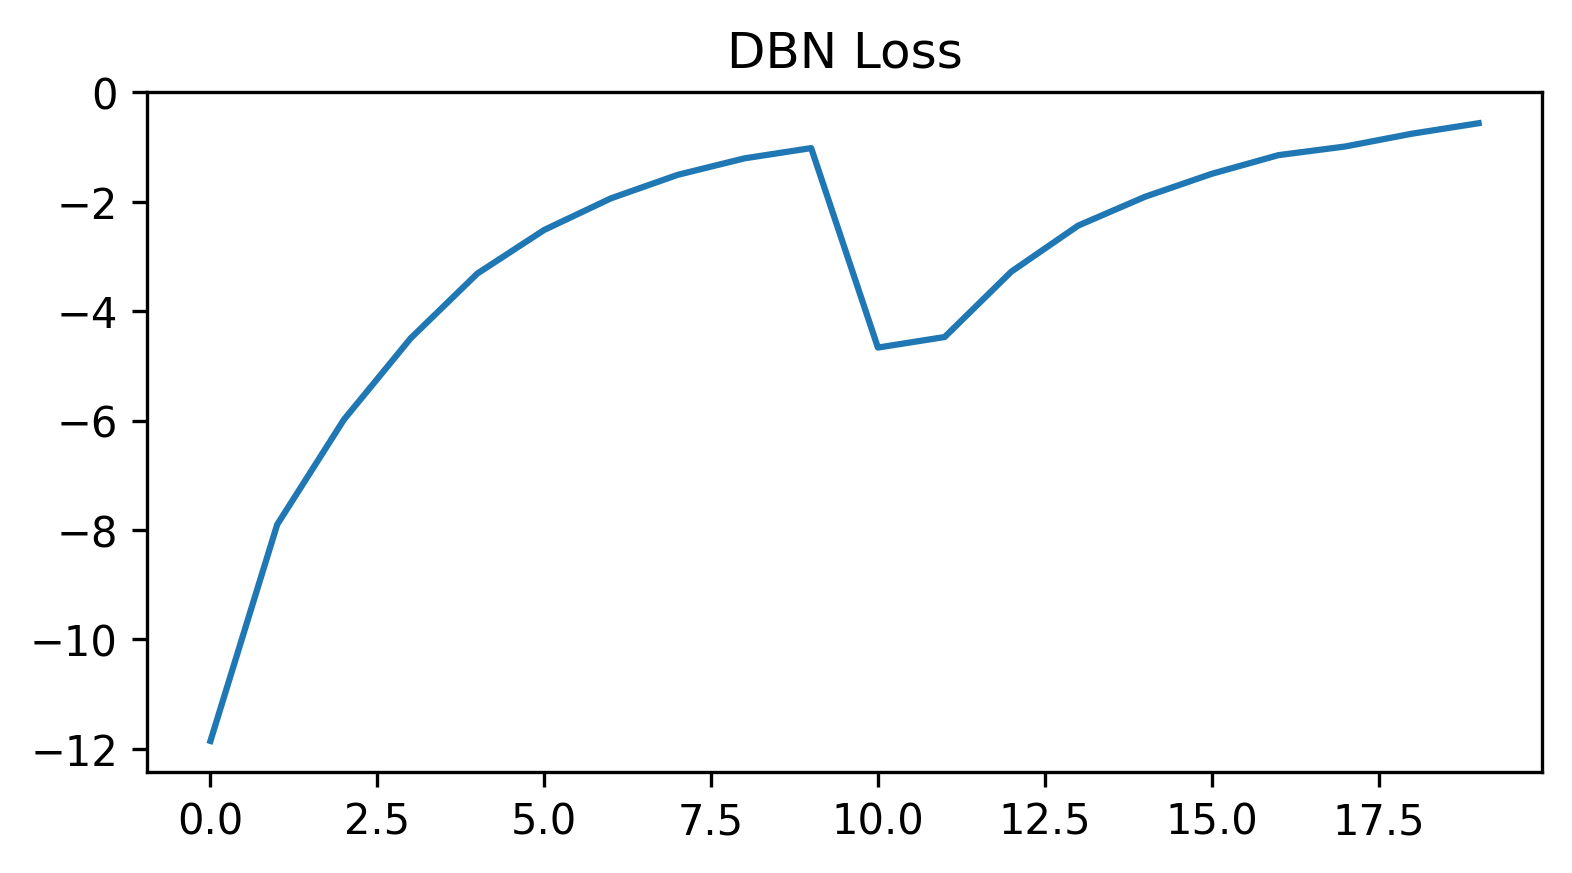

In [22]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(loss.flatten())
plt.title('DBN Loss')
plt.show()

In [23]:
test = (test_loader.dataset.data[:qtd]/255.).reshape((qtd,rbm.n_vis))

In [24]:
qtd = 32

rec = dbn.reconstruction(test)

real = show_and_save("real", make_grid(test.view(qtd,1,28,28).data))
gen = show_and_save("geradas",make_grid(rec.view(qtd,1,28,28).data))

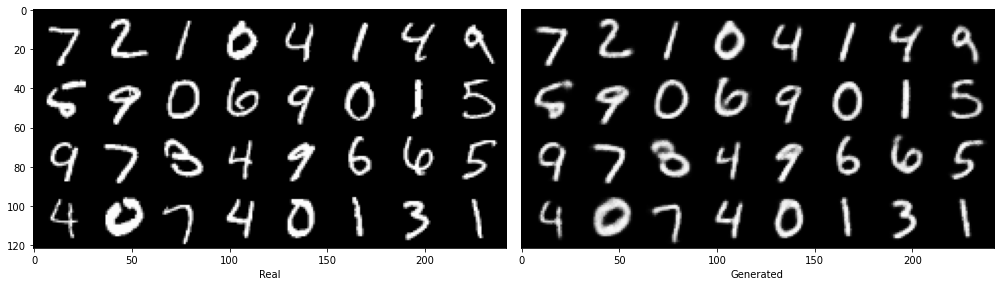

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].imshow(real)
ax[1].imshow(gen)
ax[0].set_xlabel('Real')
ax[1].set_xlabel('Generated')
#ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
#ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

In [26]:
image = create_mosaic(dbn.rbms[0].W)

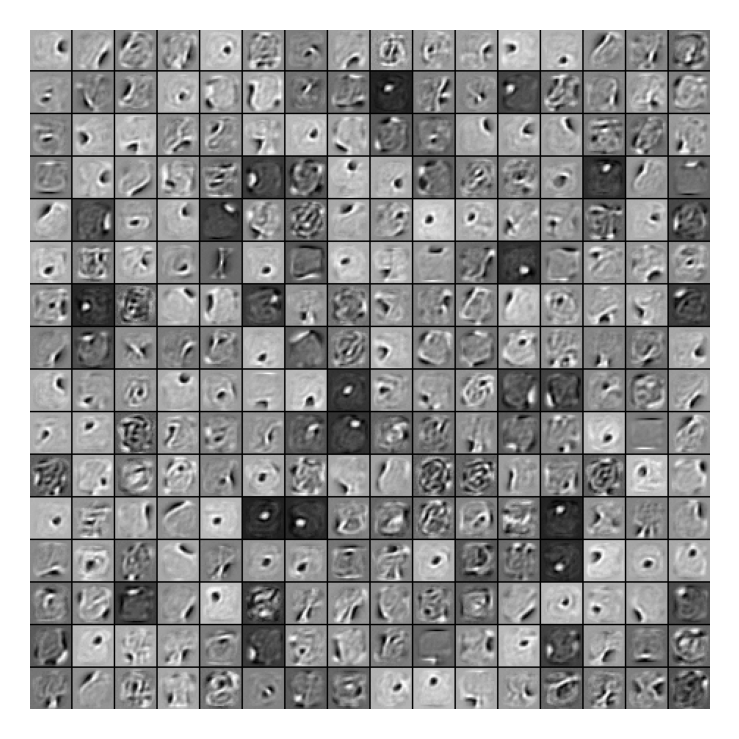

In [27]:
plt.figure(figsize=(6, 3), dpi=300)
plt.imshow(image, 'gray')
plt.axis('off')
#plt.xticks([], [])
#plt.yticks([], [])
plt.show()

# Exercícios

### Treinar duas RBMs, uma Gaussiana e uma Bernoulli sem binarização no banco de dados Fashion-MNIST para:
    Aprender a distribuição dos dados e gerar novas imagens;
    Plotar as imagens dos parâmetros aprendidos por ambos modelos, e comparar suas estatísticas;
    Utilizar os modelos treinados para treinar um classificador linear;
    
Para as RBMs Gaussianas, vocês podem utilizar a implementação da Learnergy: https://github.com/gugarosa/learnergy